# Analyzing the results for `finetuning_num_genes`

This is part 1, the results of sweeping all hyperparameter for rdkit

In [1]:
from pathlib import Path
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import seml
from matplotlib import pyplot as plt

matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-talk")
matplotlib.rcParams['font.family'] = "monospace"
plt.rcParams['savefig.facecolor'] = 'white'
sns.set_context("poster")
pd.set_option('display.max_columns', 100)

In [2]:
results = seml.get_results(
    "finetuning_num_genes",
    to_data_frame=True,
    fields=["config", "result", "seml", "config_hash"],
    states=["COMPLETED"],
    filter_dict={
        "batch_id": 3, 
        'config.dataset.data_params.split_key': 'split_ood_finetuning', # split_ood_finetuning, split_random, split_ho_pathway, split_ho_epigenetic, split_ho_epigenetic_all
        'config.model.append_ae_layer': True,
    }
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/home/icb/leon.hetzel/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


In [3]:
# Look at number of experiments per model
results["config.model.embedding.model"].value_counts()

rdkit    10
Name: config.model.embedding.model, dtype: int64

In [4]:
pd.crosstab(
    results['config.model.embedding.model'],
    results['result.perturbation disentanglement'].isnull()
)

result.perturbation disentanglement,False
config.model.embedding.model,
rdkit,10


In [5]:
[c for c in results.columns if 'ae' in c]

['config.model.append_ae_layer']

In [6]:
pd.crosstab(
    results['config.dataset.data_params.split_key'],
    results['config.model.load_pretrained']
)

config.model.load_pretrained,False,True
config.dataset.data_params.split_key,,
split_ood_finetuning,5,5


In [7]:
pd.crosstab(
    results['config.dataset.data_params.split_key'],
    results['result.loss_reconstruction'].isnull()
)

result.loss_reconstruction,False
config.dataset.data_params.split_key,
split_ood_finetuning,10


In [8]:
# columns
results.isnull().any()[results.isnull().any()]

config.model.embedding.directory    True
dtype: bool

In [9]:
# rows without nans 
clean_id = results.loc[~results['result.training'].isnull(), '_id']
# clean_id

## Preprocessing the results dataframe

In [10]:
# percentage of training runs that resulted in NaNs or totally failed

results_clean = results[results._id.isin(clean_id)].copy()
print(f"Percentage of invalid (nan) runs: {1 - len(clean_id) / len(results)}")

# Remove runs with r2 < 0.6 on the training set
# results_clean = results_clean[results_clean['result.training'].apply(lambda x: x[0][0])>0.6]

Percentage of invalid (nan) runs: 0.0


In [11]:
results_clean["config.model.embedding.model"].value_counts()

rdkit    10
Name: config.model.embedding.model, dtype: int64

In [30]:
results_clean[['config.model.load_pretrained', 'result.test_sc', 'config.model.append_ae_layer', "result.ood"]]

,config.model.load_pretrained,result.test_sc,config.model.append_ae_layer,result.ood
0,True,"[[0.32035264771362465, 0.336394493636207, 0.66...",True,"[[0.8172713799609078, 0.4985113850346318, 0.55..."
3,True,"[[0.31405868532482184, 0.3290070789219936, 0.6...",True,"[[0.8172536746219352, 0.5204826880384374, 0.76..."
5,False,"[[0.31996458716841564, 0.34342205968913603, 0....",True,"[[0.8294566499966162, 0.505241216884719, 0.811..."
6,False,"[[0.28023257808124047, 0.3110152884804152, 0.5...",True,"[[0.6604100278130284, 0.39755027437651597, 0.5..."
8,False,"[[0.320058889398603, 0.3410419780418384, 0.681...",True,"[[0.842635957731141, 0.539517444592935, 0.8299..."
9,False,"[[0.3143305154039046, 0.3379386316605025, 0.66...",True,"[[0.8156459441891423, 0.4836517340607113, 0.79..."


In [13]:
# calculate some stats
get_mean = lambda x: np.array(x)[-1, 0]
get_mean_de = lambda x: np.array(x)[-1, 1]

results_clean["result.training_mean"] = results_clean["result.training"].apply(get_mean)
results_clean["result.training_mean_de"] = results_clean["result.training"].apply(get_mean_de)
results_clean["result.val_mean"] = results_clean["result.test"].apply(get_mean)
results_clean["result.val_mean_de"] = results_clean["result.test"].apply(get_mean_de)
results_clean["result.test_mean"] = results_clean["result.ood"].apply(get_mean)
results_clean["result.test_mean_de"] = results_clean["result.ood"].apply(get_mean_de)
results_clean["result.perturbation disentanglement"] = results_clean["result.perturbation disentanglement"].apply(lambda x: x[0])
results_clean["result.final_reconstruction"] = results_clean["result.loss_reconstruction"].apply(lambda x: x[-1])

results_clean.head(3)

,_id,config_hash,seml.executable,seml.name,seml.output_dir,seml.conda_environment,seml.working_dir,seml.source_files,seml.output_file,seml.command,seml.temp_dir,config.overwrite,config.db_collection,config.dataset.data_params.covariate_keys,config.dataset.data_params.dataset_path,config.dataset.data_params.degs_key,config.dataset.data_params.dose_key,config.dataset.data_params.pert_category,config.dataset.data_params.perturbation_key,config.dataset.data_params.smiles_key,config.dataset.data_params.split_key,config.dataset.data_params.use_drugs_idx,config.dataset.dataset_type,config.model.additional_params.decoder_activation,config.model.additional_params.doser_type,config.model.additional_params.patience,config.model.additional_params.seed,config.model.append_ae_layer,config.model.embedding.directory,config.model.embedding.model,config.model.hparams.adversary_depth,config.model.hparams.adversary_lr,config.model.hparams.adversary_steps,config.model.hparams.adversary_wd,config.model.hparams.adversary_width,config.model.hparams.autoencoder_depth,config.model.hparams.autoencoder_lr,config.model.hparams.autoencoder_wd,config.model.hparams.autoencoder_width,config.model.hparams.batch_size,config.model.hparams.dim,config.model.hparams.dosers_depth,config.model.hparams.dosers_lr,config.model.hparams.dosers_wd,config.model.hparams.dosers_width,config.model.hparams.dropout,config.model.hparams.embedding_encoder_depth,config.model.hparams.embedding_encoder_width,config.model.hparams.penalty_adversary,config.model.hparams.reg_adversary,config.model.hparams.step_size_lr,config.model.load_pretrained,config.model.pretrained_model_hashes.rdkit,config.model.pretrained_model_path,config.profiling.outdir,config.profiling.run_profiler,config.training.checkpoint_freq,config.training.full_eval_during_train,config.training.max_minutes,config.training.num_epochs,config.training.run_eval_disentangle,config.training.save_checkpoints,config.training.save_dir,config.seed,result.epoch,result.stats_epoch,result.loss_reconstruction,result.loss_adv_drugs,result.loss_adv_covariates,result.penalty_adv_drugs,result.penalty_adv_covariates,result.elapsed_time_min,result.training,result.test,result.ood,result.training_sc,result.test_sc,result.ood_sc,result.perturbation disentanglement,result.optimal for perturbations,result.covariate disentanglement,result.optimal for covariates,result.total_epochs,result.training_mean,result.training_mean_de,result.val_mean,result.val_mean_de,result.test_mean,result.test_mean_de,result.final_reconstruction
0,148,c1e142e2036e1cc3dc96a3fa1d023377,compert/seml_sweep_icb.py,ft_trapnell_num_genes,/mnt/home/icb/leon.hetzel/git/CPA_graphs/sweep...,chemical_CPA,/mnt/home/icb/leon.hetzel/git/CPA_graphs,"[[compert/helper.py, 62098a95007e9f290e32086f]...",/mnt/home/icb/leon.hetzel/git/CPA_graphs/sweep...,python compert/seml_sweep_icb.py with 'model={...,/tmp/1cc10fa7-dabf-49cd-8150-8d3c670b99f7,148,finetuning_num_genes,cell_type,/storage/groups/ml01/projects/2021_chemicalCPA...,all_DEGs,dose,cov_drug_dose_name,condition,SMILES,split_ood_finetuning,True,trapnell,linear,amortized,50,1337,True,None,rdkit,4,0.000364,3,7.459343e-07,64,4,0.000561,1.329292e-07,256,128,32,3,0.000561,1.329292e-07,64,0.262378,4,128,0.072749,15.355287,50,True,4f061dbfc7af05cf84f06a724b0c8563,/storage/groups/ml01/projects/2021_chemicalCPA...,./,False,25,False,1200,400,True,True,/storage/groups/ml01/projects/2021_chemicalCPA...,307492054,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[399],"[-2615.3430031049065, -6290.5390352495015, -37...","[20745.693560123444, 20658.99501657486, 20649....","[4113.6451025009155, 4175.7913054823875, 4065....","[4.970262460177764, 3.841262038331479, 2.41895...","[0.03232072278160558, 0.007055573192587872, 0....",467.396373,"[[0.9530537324431908, 0.7043122885936317, 0.92...","[[0.815665006798493, 0.6998294557145038, 0.661...","[[0.8172713799609078, 0.4985113850346318, 0.55...","[[0.316459040704485, 0.3391961467830275, 0.923...","[[0.

In [14]:
results_clean["result.training_sc_mean"] = results_clean["result.training_sc"].apply(get_mean)
results_clean["result.training_sc_mean_de"] = results_clean["result.training_sc"].apply(get_mean_de)
results_clean["result.val_sc_mean"] = results_clean["result.test_sc"].apply(get_mean)
results_clean["result.val_sc_mean_de"] = results_clean["result.test_sc"].apply(get_mean_de)
results_clean["result.test_sc_mean"] = results_clean["result.ood_sc"].apply(get_mean)
results_clean["result.test_sc_mean_de"] = results_clean["result.ood_sc"].apply(get_mean_de)

results_clean = results_clean[results_clean["result.val_sc_mean"] > 0.01]
results_clean = results_clean[results_clean["result.val_mean_de"] > 0.4]
# results_clean = results_clean[results_clean["config.model.append_ae_layer"] == True]

In [15]:
# results_clean["config.model.load_pretrained"]

<AxesSubplot:xlabel='config.model.load_pretrained', ylabel='result.final_reconstruction'>

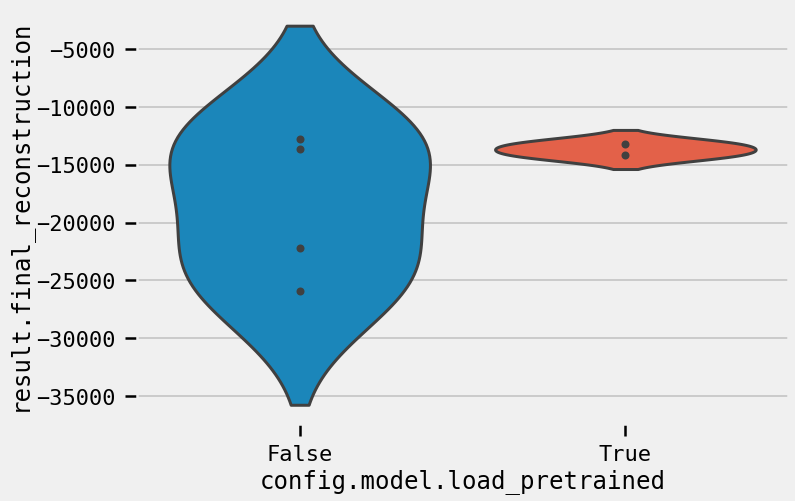

In [16]:
# results_clean.plot.box(by="config.model.load_pretrained", y="result.final_reconstruction")
sns.violinplot(data=results_clean, x="config.model.load_pretrained", y="result.final_reconstruction", inner='point', scale='width')

## Look at early stopping

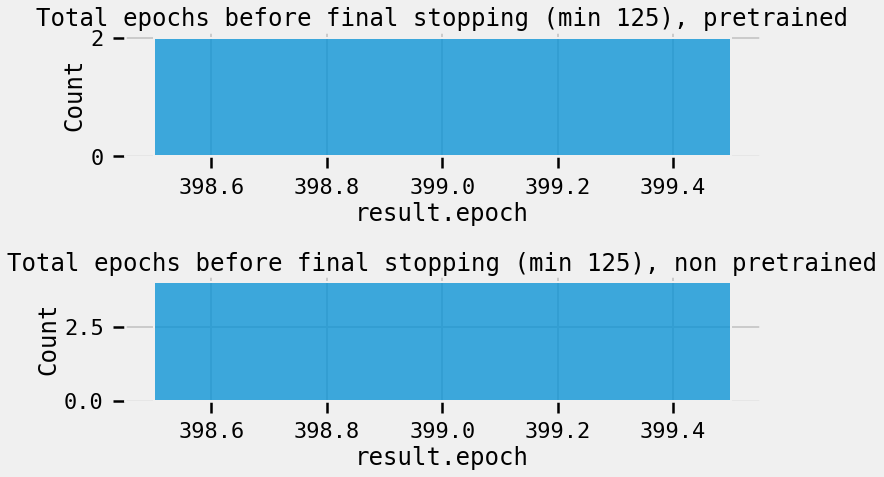

In [17]:
fig, ax = plt.subplots(2,1)
sns.histplot(data=results_clean[results_clean['config.model.load_pretrained']==True]["result.epoch"].apply(max), ax=ax[0])
ax[0].set_title("Total epochs before final stopping (min 125), pretrained")

ax[1] = sns.histplot(data=results_clean[results_clean['config.model.load_pretrained']==False]["result.epoch"].apply(max), ax=ax[1])
ax[1].set_title("Total epochs before final stopping (min 125), non pretrained")

plt.tight_layout()

## Look at $r^2$ reconstruction

In [18]:
[c for c in results_clean.columns if 'pretrain' in c]

results_clean[["config.model.embedding.model", 'config.model.load_pretrained', 'config.model.append_ae_layer']]

,config.model.embedding.model,config.model.load_pretrained,config.model.append_ae_layer
0,rdkit,True,True
3,rdkit,True,True
5,rdkit,False,True
6,rdkit,False,True
8,rdkit,False,True
9,rdkit,False,True


### DE genes

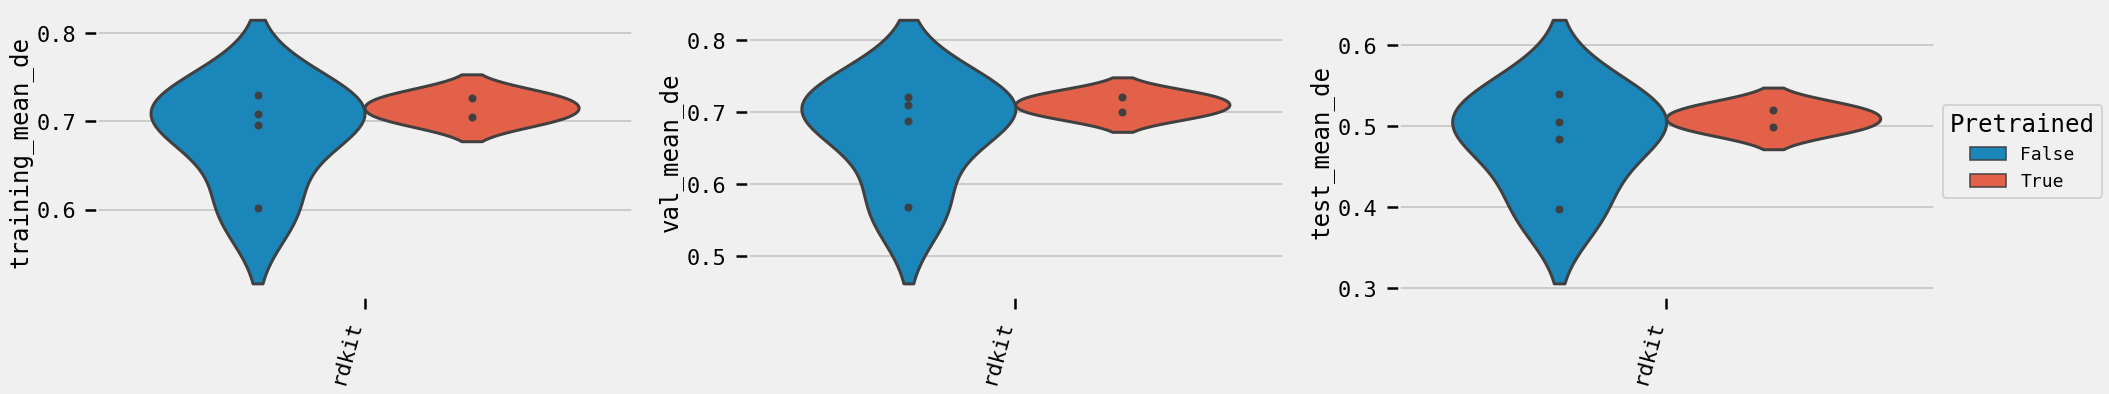

In [19]:
# DE genes
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(("result.training_mean_de", "result.val_mean_de", "result.test_mean_de")):
    sns.violinplot(
        data=results_clean, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    # ax[i].set_ylim([0.3,1.01])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    ax[i].legend(title='Pretrained',loc='lower right', fontsize=18, title_fontsize=24)

ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[2].legend(title='Pretrained', fontsize=18, title_fontsize=24, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

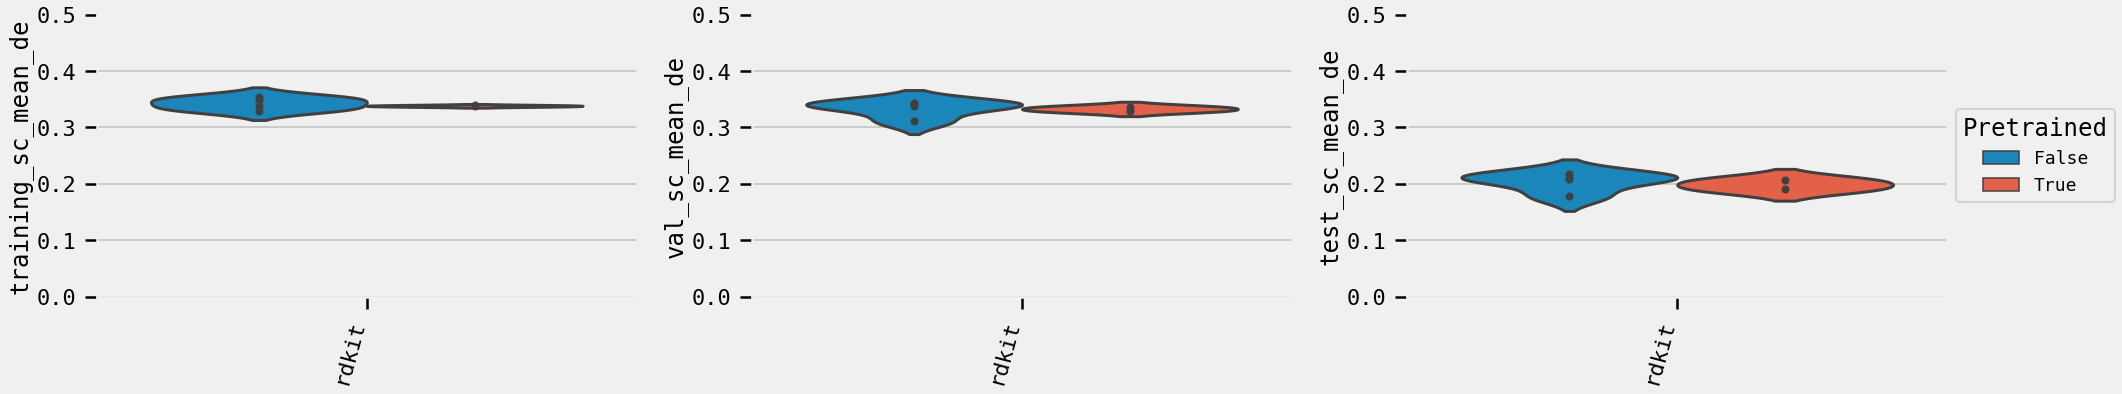

In [20]:
# DE genes
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(("result.training_sc_mean_de", "result.val_sc_mean_de", "result.test_sc_mean_de")):
    sns.violinplot(
        data=results_clean, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    ax[i].set_ylim([0.0,0.5])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    ax[i].legend(title='Pretrained',loc='lower right', fontsize=18, title_fontsize=24)

ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[2].legend(title='Pretrained', fontsize=18, title_fontsize=24, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

### All genes

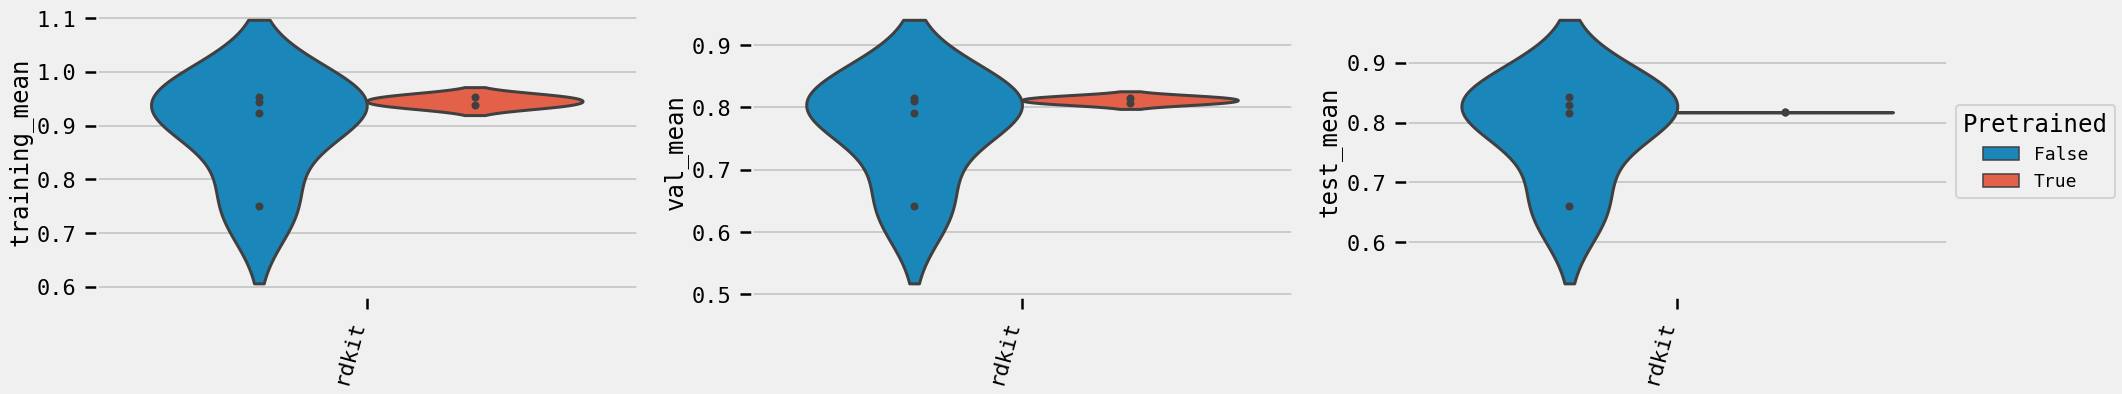

In [21]:
# DE genes
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(("result.training_mean", "result.val_mean", "result.test_mean")):
    sns.violinplot(
        data=results_clean, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    # ax[i].set_ylim([0.3,1.01])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    ax[i].legend(title='Pretrained',loc='lower right', fontsize=18, title_fontsize=24)

ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[2].legend(title='Pretrained', fontsize=18, title_fontsize=24, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Look at disentanglement scores

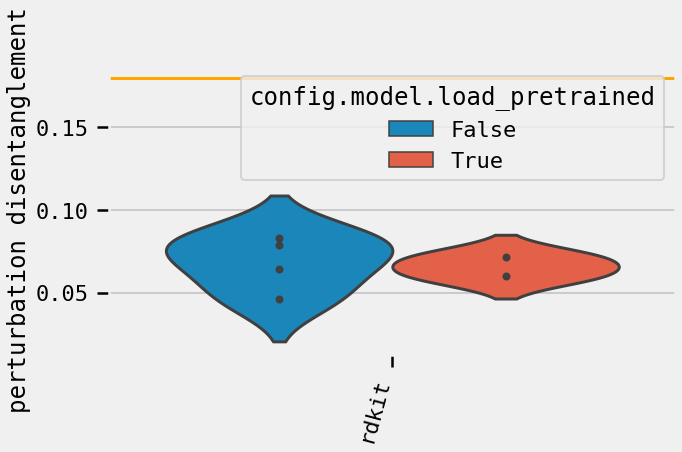

In [22]:
rows = 1 
cols = 1
fig, ax = plt.subplots(rows, cols, figsize=(10*cols, 6*rows), sharex=True)

for y in ["result.perturbation disentanglement"]:
    sns.violinplot(data=results_clean, x="config.model.embedding.model", y=y,hue='config.model.load_pretrained', inner='point' ,ax=ax, scale='width')
    # ax[i].set_ylim([0,1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha='right')
    ax.axhline(0.18, color='orange')
    ax.set_xlabel('')
    ax.set_ylabel(y.split('.')[-1])
plt.tight_layout()

## Subselect to disentangled models

In [23]:
n_top = 2
performance_condition = lambda emb, pretrained, max_entangle: (results_clean["config.model.embedding.model"] == emb) & (results_clean["result.perturbation disentanglement"] < max_entangle) & (results_clean["config.model.load_pretrained"] == pretrained)

best = []
for embedding in list(results_clean["config.model.embedding.model"].unique()):
    for pretrained in [True, False]:
        df = results_clean[performance_condition(embedding, pretrained, 0.8)]
        print(embedding, pretrained, len(df))
        best.append(df.sort_values(by="result.val_mean_de", ascending=False).head(n_top))

best = pd.concat(best)

rdkit True 2
rdkit False 4


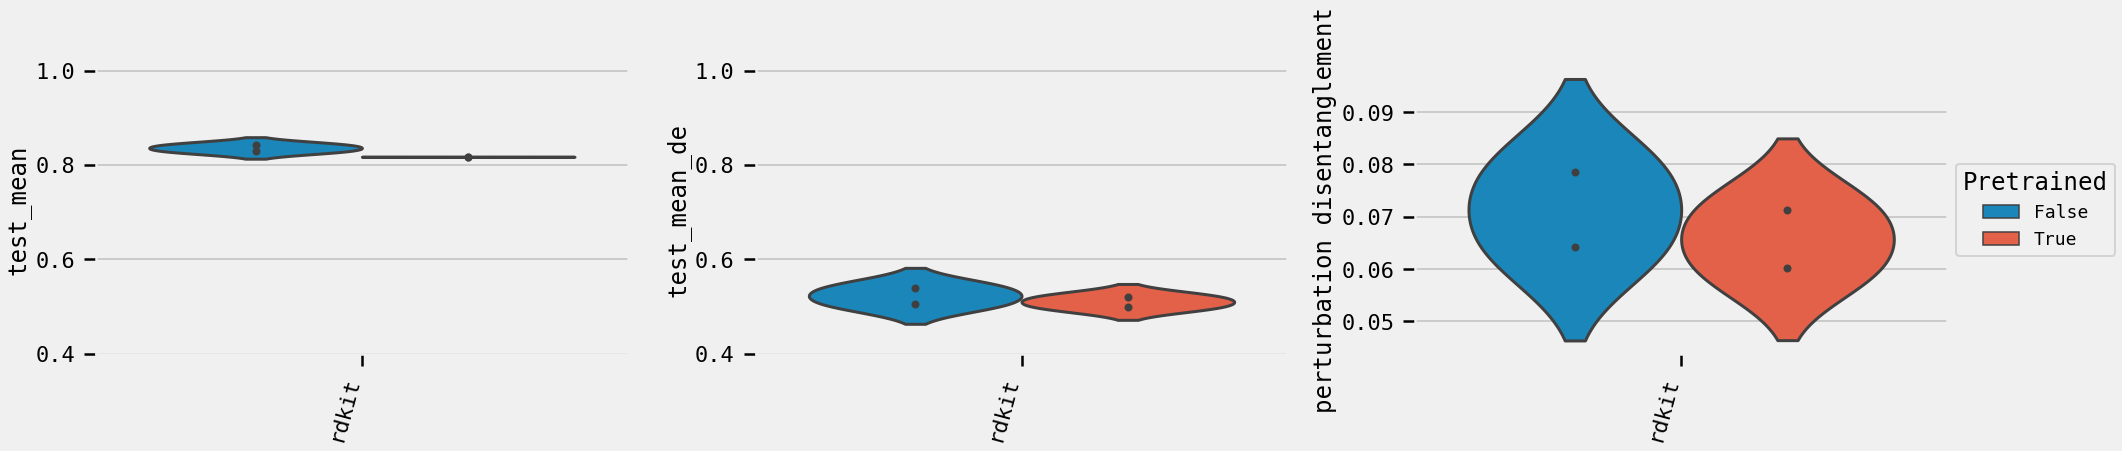

In [24]:
# All genes, DE genes, disentanglement
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(["result.test_mean", "result.test_mean_de", "result.perturbation disentanglement"]):
    sns.violinplot(
        data=best, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    ax[i].legend(title='Pretrained',loc='lower right', fontsize=18, title_fontsize=24)
ax[0].get_legend().remove()
ax[0].set_ylim([0.4, 1.01])
ax[1].get_legend().remove()
ax[1].set_ylim([0.4, 1.01])
ax[2].legend(title='Pretrained', fontsize=18, title_fontsize=24, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()


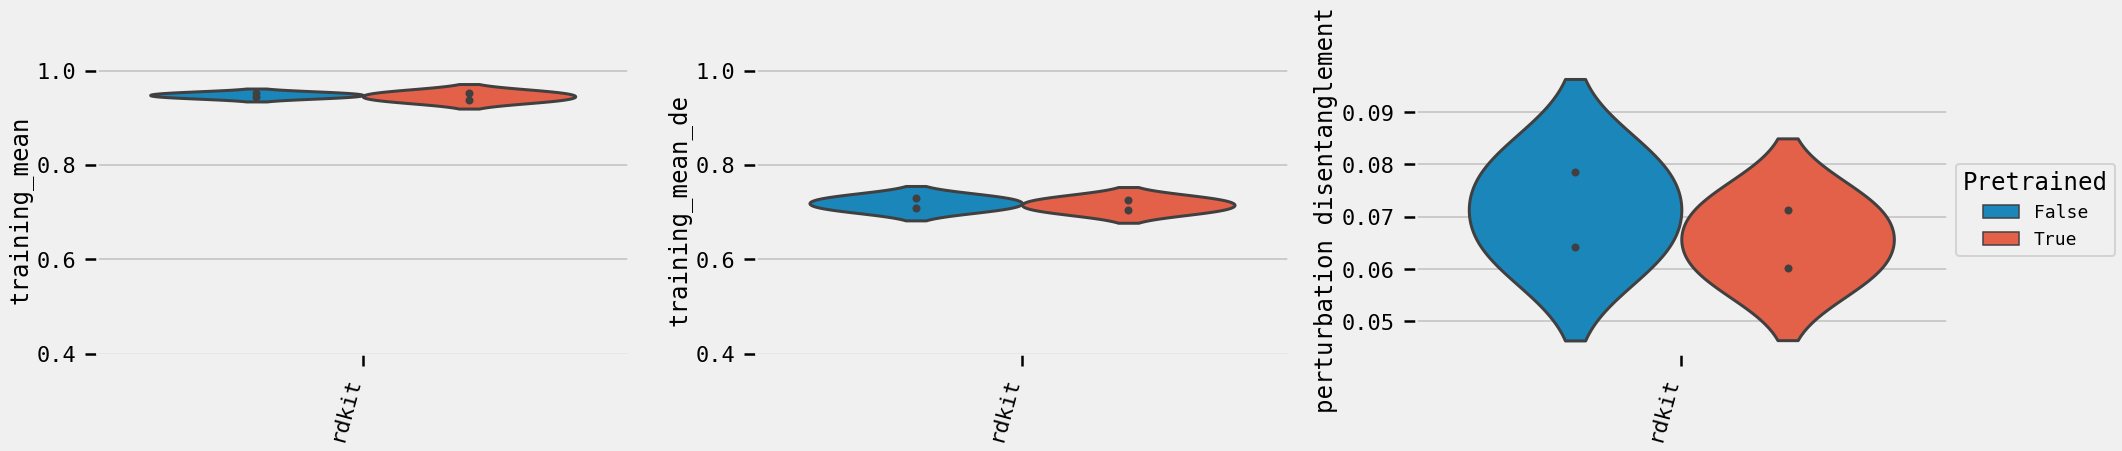

In [25]:
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(["result.training_mean", "result.training_mean_de", "result.perturbation disentanglement"]):
    sns.violinplot(
        data=best, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
ax[0].get_legend().remove()
ax[0].set_ylim([0.4, 1.01])
ax[1].get_legend().remove()
ax[1].set_ylim([0.4, 1.01])
ax[2].legend(title='Pretrained', fontsize=18, title_fontsize=24, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Take a deeper look in the `.config` of the best performing models

In [27]:
[c for c in best.columns if 'hash' in c]

['config_hash', 'config.model.pretrained_model_hashes.rdkit']

In [29]:
best[['config.model.load_pretrained', 'config_hash', 'result.test_mean_de']]

,config.model.load_pretrained,config_hash,result.test_mean_de
3,True,bd001c8d557edffe9df9e6bf09dc4120,0.520483
0,True,c1e142e2036e1cc3dc96a3fa1d023377,0.498511
8,False,6e9d00880375aa450a8e5de60250659f,0.539517
5,False,efd377826073474501e14040ed3649a8,0.505241
